<a href="https://colab.research.google.com/github/Mohamed2bdelaziz/Active-Learning/blob/main/text_classification_with_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install git+https://github.com/modAL-python/modAL.git
! pip install scikeras


In [44]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import keras
from sklearn.model_selection import train_test_split
import tensorflow
from keras.layers import Embedding
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, ReLU, GlobalMaxPooling1D, Concatenate
from keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
! kaggle datasets download -d praveengovi/emotions-dataset-for-nlp
! unzip emotions-dataset-for-nlp.zip -d /content/emotions-dataset-for-nlp

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 54.5MB/s]
Archive:  emotions-dataset-for-nlp.zip
  inflating: /content/emotions-dataset-for-nlp/test.txt  
  inflating: /content/emotions-dataset-for-nlp/train.txt  
  inflating: /content/emotions-dataset-for-nlp/val.txt  


In [4]:
# download the pretrained glove models embeddings
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-01 04:32:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 39s  

2024-05-01 04:35:20 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [5]:
data_path = os.path.join('/content/emotions-dataset-for-nlp')
os.listdir(data_path)

['train.txt', 'test.txt', 'val.txt']

In [6]:
def load_data(
    data_path = data_path
):
    data = dict()
    for file in os.listdir(data_path):
        name = file.split('.')[0]
        data[name] = list()
        with open(os.path.join(data_path, file), "r") as f:
            print('Loading {} Data ..'.format(name))
            for line in tqdm(f):
                text, label = line.split(';')
                data[name].append({
                    'text' : text.strip(),
                    'label' : label.strip()
                })

    return data


In [7]:
data = load_data()

Loading train Data ..


16000it [00:00, 243241.48it/s]


Loading test Data ..


2000it [00:00, 374290.92it/s]


Loading val Data ..


2000it [00:00, 426337.06it/s]


In [8]:
train_df = pd.DataFrame(
    data['train']
)

train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
val_df = pd.DataFrame(
    data['val']
)
test_df = pd.DataFrame(
    data['test']
)


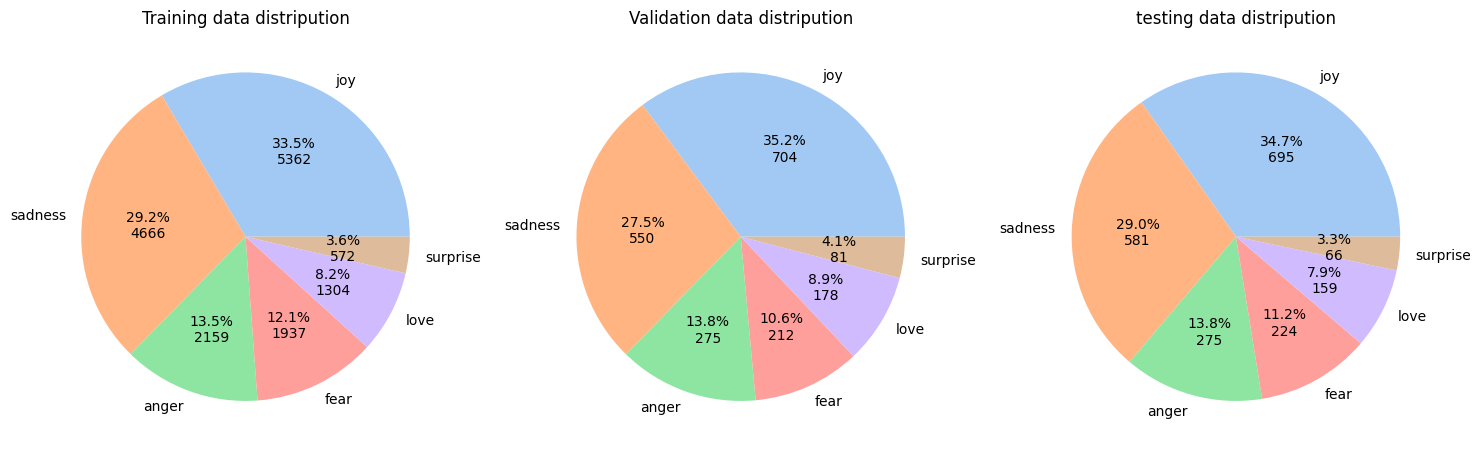

In [10]:
colors = sns.color_palette("pastel")

plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.pie(
    train_df.label.value_counts(),
    labels=train_df.label.value_counts().index,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(train_df)*x/100)
)
plt.title('Training data distripution')

plt.subplot(1, 3, 2)
plt.pie(
    val_df.label.value_counts(),
    labels=val_df.label.value_counts().index,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(val_df)*x/100)
)
plt.title('Validation data distripution')

plt.subplot(1, 3, 3)
plt.pie(
    test_df.label.value_counts(),
    labels=test_df.label.value_counts().index,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(test_df)*x/100)
)
plt.title('testing data distripution')

plt.tight_layout()
plt.show()

In [11]:
all_train_text = train_df.text.values
all_train_text = " ".join(all_train_text)
unique_list = list(set(all_train_text.split()))

print("Training data got {} unique words.".format(len(unique_list)))
# all_train_text

Training data got 15212 unique words.


In [12]:
vectorizer = keras.layers.TextVectorization(max_tokens=15000, output_sequence_length=100)
text_ds = tensorflow.data.Dataset.from_tensor_slices(train_df.text.values).batch(128)
vectorizer.adapt(text_ds)

In [13]:
next(iter(text_ds))[:10], len(text_ds)

(<tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'i didnt feel humiliated',
        b'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
        b'im grabbing a minute to post i feel greedy wrong',
        b'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
        b'i am feeling grouchy',
        b'ive been feeling a little burdened lately wasnt sure why that was',
        b'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
        b'i feel as confused about life as a teenager or as jaded as a year old man',
        b'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
        b'i feel romantic too'], dtype=object)>,
 125)

In [14]:
test_sent = "I love the selected topics in artificial intelligence two course".lower()
output = vectorizer([[test_sent]])
output.numpy()

array([[    2,    85,     6,  5772,  5484,    12, 14850,  3846,   219,
          704,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

In [15]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

dict(zip(test_sent.split(), [word_index[w] for w in test_sent.split()]))

{'i': 2,
 'love': 85,
 'the': 6,
 'selected': 5772,
 'topics': 5484,
 'in': 12,
 'artificial': 14850,
 'intelligence': 3846,
 'two': 219,
 'course': 704}

In [16]:
print('Vectorizing training text data...')
X_train = np.array(list(map(vectorizer, tqdm(train_df.text.values))))

print('Vectorizing validation text data...')
X_val = np.array(list(map(vectorizer, tqdm(val_df.text.values))))

print('Vectorizing testing text data...')
X_test = np.array(list(map(vectorizer, tqdm(test_df.text.values))))

Vectorizing training text data...


100%|██████████| 16000/16000 [05:43<00:00, 46.53it/s]


Vectorizing validation text data...


100%|██████████| 2000/2000 [00:28<00:00, 70.35it/s] 


Vectorizing testing text data...


100%|██████████| 2000/2000 [00:21<00:00, 91.75it/s]


In [17]:
hot_encoder = OneHotEncoder().fit(train_df.label.values.reshape(-1, 1))

y_train = hot_encoder.transform(train_df.label.values.reshape(-1, 1)).toarray()
y_val = hot_encoder.transform(val_df.label.values.reshape(-1, 1)).toarray()
y_test = hot_encoder.transform(test_df.label.values.reshape(-1, 1)).toarray()

In [18]:
X_train.shape, y_val.shape

((16000, 100), (2000, 6))

In [19]:
path_to_glove_file = "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    print("loading glove embeddings..")
    for line in tqdm(f.readlines()):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


loading glove embeddings..


100%|██████████| 400000/400000 [00:31<00:00, 12827.39it/s]


Found 400000 word vectors.


In [20]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 14034 words (966 misses)


In [21]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [22]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = keras.layers.Dropout(0.5)(embedded_sequences) # 0.4
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(128, 5, activation="relu", padding = 'same')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
preds = keras.layers.Dense(train_df.label.nunique(), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 300)           │       4,500,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 128)           │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 128)           │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, None, 128)           │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,874,110 (18.59 MB)

 Trainable params: 373,510 (1.42 MB)

 Non-trainable params: 4,500,600 (17.17 MB)

In [87]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop", # adam
    metrics=["acc", F1Score()]
)

In [88]:
# create the classifier
classifier = KerasClassifier(model)

In [89]:
def random_sampling(classifier, X, n_instances=1000, verbose=0):
    query_idx = np.random.choice(range(len(X)), n_instances, replace=False)
    return query_idx, X[query_idx]

query_strategies = {
    "Random_Sampling": random_sampling,
    "Uncertainty_Sampling": uncertainty_sampling,
    "Margin_Sampling": margin_sampling,
    "Entropy_Sampling": entropy_sampling
}

In [ ]:
history = {}
models = {}

for query_strategy_name in query_strategies.keys():
  # assemble initial data
  n_initial = 1000
  initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
  X_initial = X_train[initial_idx]
  y_initial = y_train[initial_idx]

  # generate the pool
  # remove the initial data from the training dataset
  X_pool = np.delete(X_train, initial_idx, axis=0)
  y_pool = np.delete(y_train, initial_idx, axis=0)

  # initialize ActiveLearner
  models[query_strategy_name] = ActiveLearner(
      estimator=classifier,
      X_training=X_initial, y_training=y_initial,
      query_strategy=query_strategies[query_strategy_name],
      verbose=1
  )

  acc_hist = list()
  f1_hist = list()

  # the active learning loop
  n_queries =  12
  for idx in range(n_queries):
      print('Query no. %d' % (idx + 1) + f', using {query_strategy_name} strategy')
      query_idx, query_instance = models[query_strategy_name].query(X_pool, n_instances=500, verbose=0)
      models[query_strategy_name].teach(
          X=X_pool[query_idx], y=y_pool[query_idx], only_new=False,
          verbose=1
      )

      # getting teching history
      y_pred = models[query_strategy_name].predict(X_test)
      acc_hist.append(f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro'))
      f1_hist.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

      # remove queried instance from pool
      X_pool = np.delete(X_pool, query_idx, axis=0)
      y_pool = np.delete(y_pool, query_idx, axis=0)
  history[query_strategy_name] = {
      "acc_hist" : acc_hist,
      "f1_hist" : f1_hist,
      }


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - acc: 0.8018 - f1_score: 0.7192 - loss: 0.1676
Query no. 1, using Random_Sampling strategy
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - acc: 0.8412 - f1_score: 0.7927 - loss: 0.1389
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step
Query no. 2, using Random_Sampling strategy
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - acc: 0.8689 - f1_score: 0.8521 - loss: 0.1152
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
Query no. 3, using Random_Sampling strategy
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - acc: 0.8662 - f1_score: 0.8293 - loss: 0.1119
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Query no. 4, using Random_Sampling strategy
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - acc: 0.8628 - f1_score: 0.8217 - loss: 0.1160
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Query no. 5, using Random_Sampling strategy
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - acc: 0.8834 - f1_score: 0.8498 - loss: 0.1035
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
Query no. 6, using Random_Sampling strate

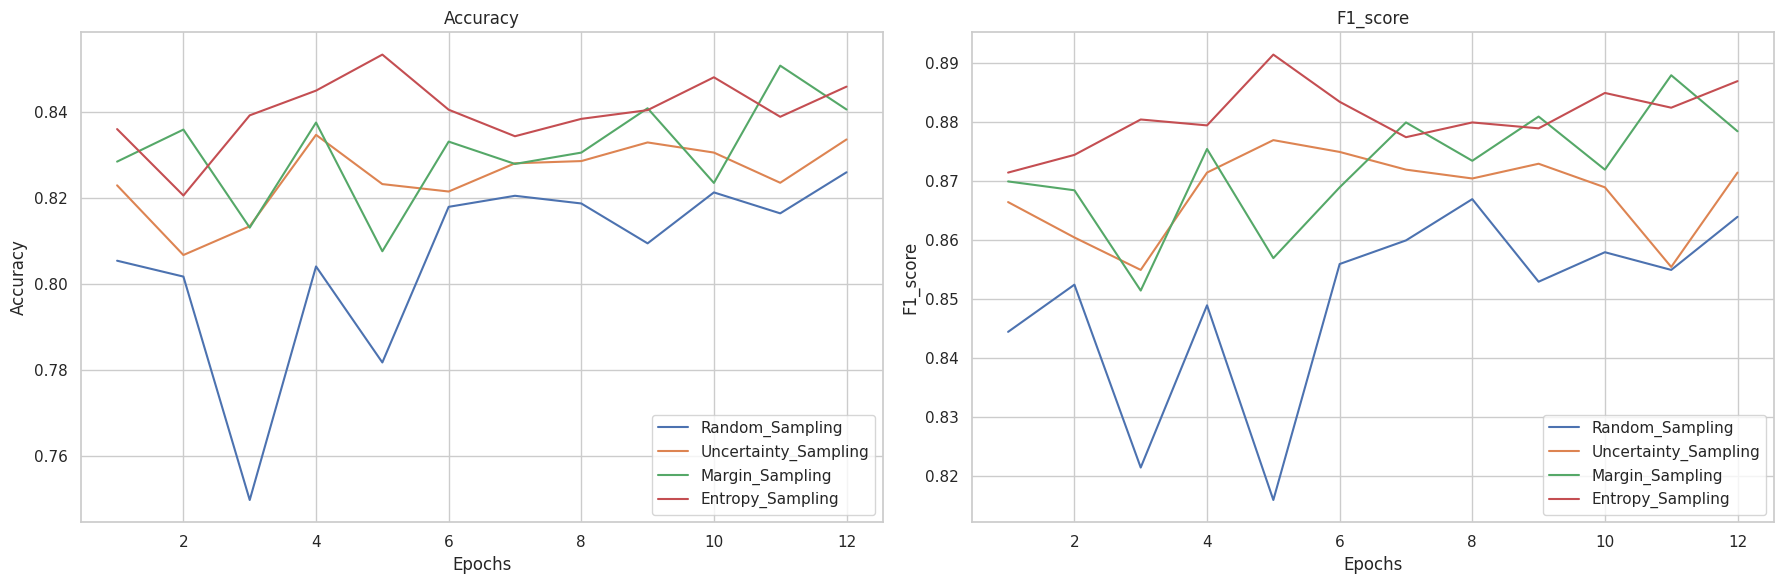

In [92]:
# Set up the figure
plt.figure(figsize=(18, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
for strat_nmae in history.keys():
  plt.plot(range(1, len(history[strat_nmae]['acc_hist']) + 1), history[strat_nmae]['acc_hist'], label=strat_nmae)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation f1_score
plt.subplot(1, 2, 2)
for strat_nmae in history.keys():
  plt.plot(range(1, len(history[strat_nmae]['f1_hist']) + 1), history[strat_nmae]['f1_hist'], label=strat_nmae)
plt.title('F1_score')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()

# Customize the style using Seaborn
sns.set(style='whitegrid')  # You can choose other styles as well

# Show the plots
plt.grid(True)
plt.tight_layout()
plt.show()




In [59]:
# help(ActiveLearner)

In [60]:
# acc_hist = list()
# f1_hist = list()

# # the active learning loop
# n_queries =  6
# for idx in range(n_queries):
#     print('Query no. %d' % (idx + 1))
#     query_idx, query_instance = learner.query(X_pool, n_instances=500, verbose=0)
#     learner.teach(
#         X=X_pool[query_idx], y=y_pool[query_idx], only_new=False,
#         verbose=1
#     )

#     # getting teching history
#     y_pred = learner.predict(X_test)
#     acc_hist.append(f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro'))
#     f1_hist.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

#     # remove queried instance from pool
#     X_pool = np.delete(X_pool, query_idx, axis=0)
#     y_pool = np.delete(y_pool, query_idx, axis=0)

#     # getting measures

Query no. 1
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - acc: 0.4579 - f1_score: 0.2131 - loss: 0.3732
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Query no. 2
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - acc: 0.4880 - f1_score: 0.2794 - loss: 0.3565
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Query no. 3
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - acc: 0.5523 - f1_score: 0.3445 - loss: 0.3289
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
Query no. 4
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - acc: 0.6264 - f1_score: 0.4105 - loss: 0.2920
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
Query no. 5
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - acc: 0.7089 - f1_score: 0.4773 - loss: 0.2344
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Query no. 6
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - acc: 0.7797 - f1_score: 0.5682 - loss: 0.1921
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


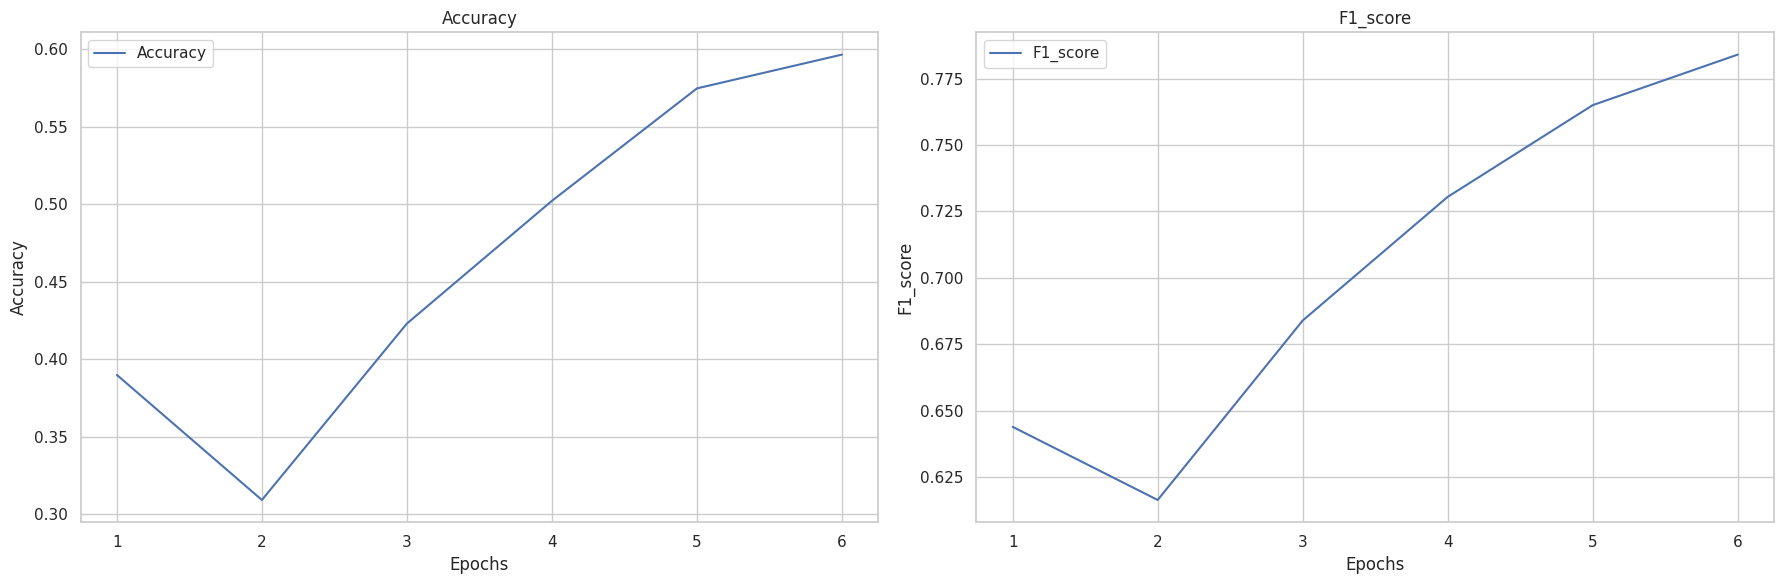

In [61]:
# # Set up the figure
# plt.figure(figsize=(18, 6))

# # Plot training and validation accuracy
# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(acc_hist) + 1), acc_hist, label='Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training and validation f1_score
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(f1_hist) + 1), f1_hist, label='F1_score')
# plt.title('F1_score')
# plt.xlabel('Epochs')
# plt.ylabel('F1_score')
# plt.legend()

# # Customize the style using Seaborn
# sns.set(style='whitegrid')  # You can choose other styles as well

# # Show the plots
# plt.grid(True)
# plt.tight_layout()
# plt.show()